In [2]:
print("radhe radhe")

radhe radhe


In [3]:
from dotenv import load_dotenv
import os

load_dotenv()

# IMPORT DATASET PATH
DATASET_PATH= os.getenv("DATASET_PATH")

In [4]:
import pandas as pd
df=pd.read_csv(DATASET_PATH,index_col="Date",parse_dates=["Date"],dayfirst=False)
df

,Bankura_temp,Birbhum_temp,Burdwan_temp,Darjeeling_temp,Hooghly_temp,Howrah_temp,Jalpaiguri_temp,Kochbihar_temp,Kolkata_temp,Malda_temp,Medinipur_temp,Murshidabad_temp,Nadia_temp,North-24-Parganas_temp,North-Dinajpur_temp,Purulia_temp,South-24-Parganas_temp,South-Dinajpur_temp
Date,,,,,,,,,,,,,,,,,,
1901-01-01,17.970,17.405,18.108,14.058,18.897,19.161,15.593,15.917,19.106,15.670,18.889,17.540,18.428,18.522,15.151,17.159,15.968,16.580
1901-02-01,21.334,21.435,21.879,16.913,22.437,22.497,18.650,19.243,22.600,19.754,21.892,21.501,22.215,21.830,18.845,20.297,18.558,20.409
1901-03-01,26.523,26.422,26.913,21.394,27.463,27.343,23.034,23.535,27.495,24.729,26.686,26.360,26.938,26.097,23.732,25.467,22.129,25.228
1901-04-01,31.712,31.807,31.968,25.806,31.886,31.445,27.258,27.823,31.686,30.027,30.972,31.581,31.725,29.794,28.800,30.974,25.039,30.325
1901-05-01,32.202,31.714,31.934,26.155,31.622,31.316,27.323,27.809,31.392,29.840,31.223,31.243,31.368,29.616,28.859,32.114,25.069,29.959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002-08-01,28.106,28.499,28.547,27.061,28.633,28.567,28.438,29.013,28.697,28.286,27.852,28.819,28.898,27.609,28.474,27.416,23.336,29.026
2002-09-01,28.072,28.519,28.568,26.502,28.653,28.603,27.949,28.511,28.700,28.224,27.888,28.916,29.102,27.743,28.198,27.325,23.492,29.013
2002-10-01,26.541,27.130,27.294,25.052,27.605,27.644,26.433,26.938,27.800,26.828,26.773,27.597,27.991,26.991,26.759,25.715,22.852,27.534


In [6]:
from dash import callback
import pandas as pd
from keras.callbacks import Callback
import numpy as np
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import r2_score
import datetime
from dateutil.relativedelta import relativedelta

# --- Custom Callback ---
class LossThresholdCallback(Callback):
    def __init__(self, threshold=0.6):
        super().__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('loss') is not None and logs.get('loss') < self.threshold:
            print(f"\nStopping training as loss{logs.get('loss')} < {self.threshold}")
            self.model.stop_training = True

# --- Define sequence splitter ---
def split_sequence(sequence, n_step):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_step
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# --- Set training & testing window ---
train_end_date = datetime.datetime(1992, 12, 1)
n_steps = 15

# Split into training, overlapping test for context, and actual test for evaluation
train_data = df[:train_end_date]
train_test_data = df[train_end_date - relativedelta(months=n_steps - 1):]
acc_test_data = df[train_end_date + relativedelta(months=1):]  # Actual test window
lstm_pred_data = acc_test_data.copy()  # To store predictions

# --- For each column (district) ---
for col in df.columns[3:4]:  # Skip first three columns (Date, District, State)
    print(f"Training LSTM for column: {col}")
# col="Darjeeling_temp"
    # --- Prepare data ---
    X_train, y_train = split_sequence(train_data[col], n_step=n_steps)
    X_test, y_test = split_sequence(train_test_data[col], n_step=n_steps)

    # Reshape for LSTM input
    n_features = 1
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

    # --- Build the model ---
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # --- Train the model ---
    model.fit(X_train, y_train, epochs=25, verbose=1,callbacks=[LossThresholdCallback(threshold=0.7)])

    # --- Predict ---
    pred = model.predict(X_test, verbose=0)
    # print(pred)

    # Align predictions to actual date index
    pred_index = acc_test_data.index[:len(pred)]
    pred_series = pd.Series(pred.flatten(), index=pred_index)
    # print(pred_series)

    # Store in results dataframe
    lstm_pred_data[col] = pred_series

    # Calculate R² score
    r2 = r2_score(acc_test_data[col], lstm_pred_data[col])
    print(f"R² Score for {col}: {r2:.4f}")


Training LSTM for column: Darjeeling_temp


/tmp/ipykernel_99304/3997819850.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]


Epoch 1/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 512.6728
Epoch 2/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.3876
Epoch 3/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0082
Epoch 4/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1597
Epoch 5/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6768
Epoch 6/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8293
Epoch 7/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1413
Epoch 8/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8542
Epoch 9/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9321
Epoch 10/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8367
Epoch 11/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7700
Epoch 12/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9160
Epoch 13/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7810
Epoch 14/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7528
Epoch 15/25
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9124
Epoch 16/25
35/3

In [ ]:
lstm_pred_data.to_csv("lstm_pred_data.csv", index="Date")

Bankura_temp: 0.9181780985507889
Birbhum_temp: 0.9724874955782215
Burdwan_temp: 0.9637704351218268
Darjeeling_temp: 0.926723670009066
Hooghly_temp: 0.9271735752455821
Howrah_temp: 0.9547627210501852
Jalpaiguri_temp: 0.9538470819602124
Kochbihar_temp: 0.9634605166404083
Kolkata_temp: 0.9485792470888676
Malda_temp: 0.9519393311736396
Medinipur_temp: 0.951982906799848
Murshidabad_temp: 0.9652797094291132
Nadia_temp: 0.9592572507162318
North-24-Parganas_temp: 0.9524906088775993
North-Dinajpur_temp: 0.9705821968377871
Purulia_temp: 0.9649475706868981
South-24-Parganas_temp: 0.9062466578446688
South-Dinajpur_temp: 0.9601400131019824


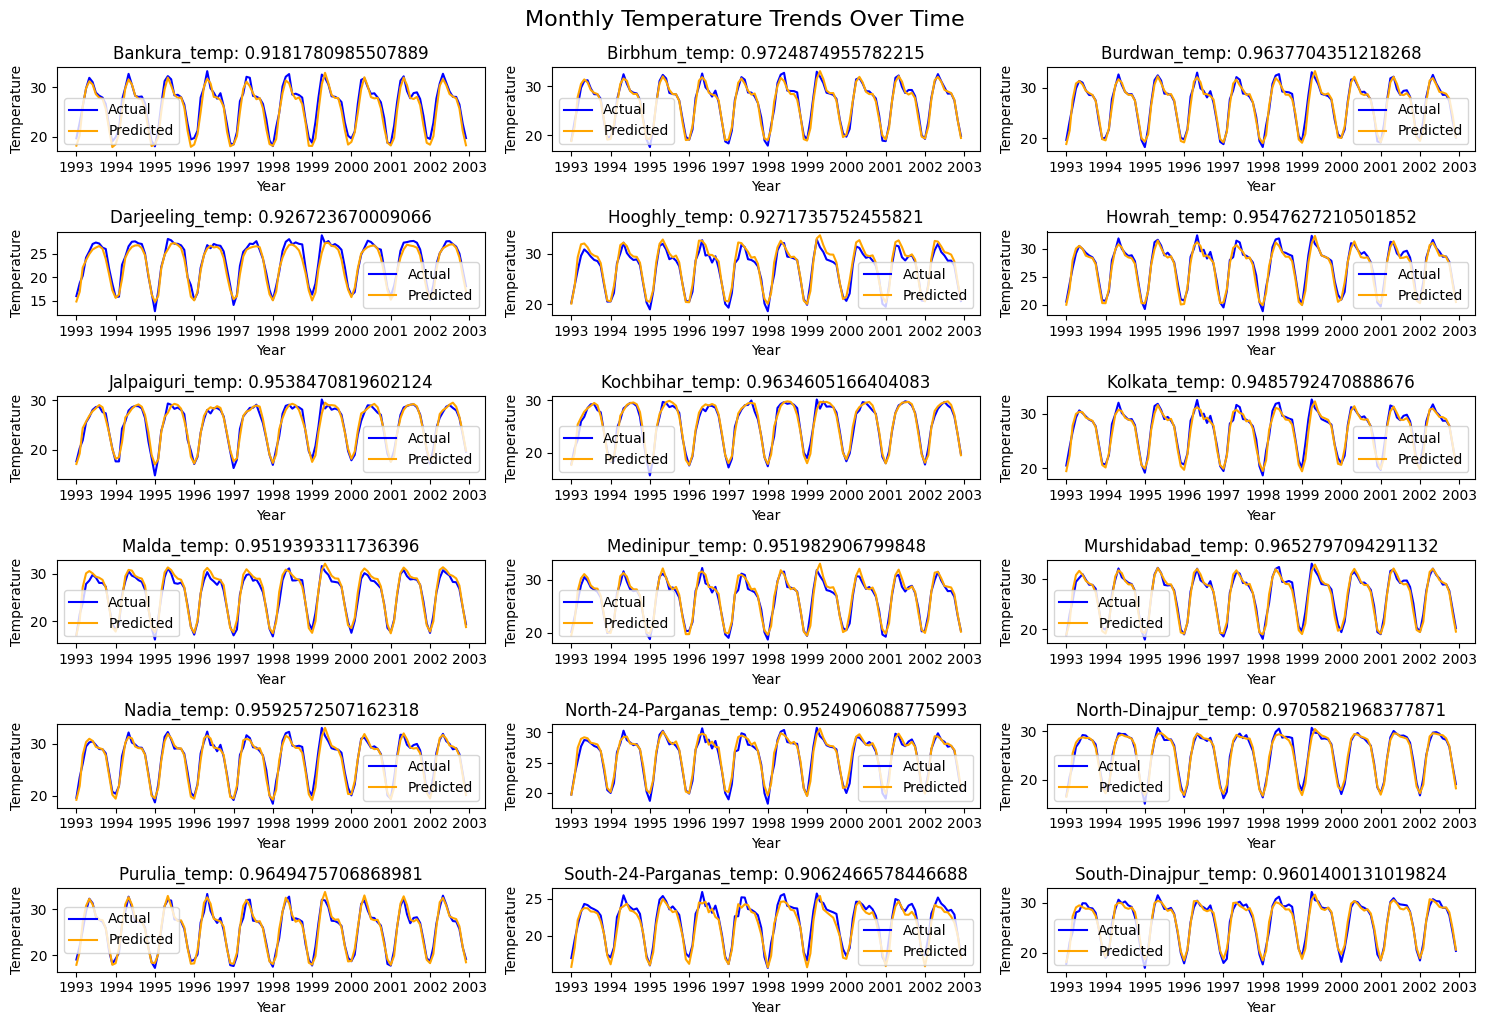

In [ ]:
import matplotlib.pyplot as plt

# Ensure inline plotting for Jupyter
%matplotlib inline  

test_data=acc_test_data.copy()

# find r2 score
from sklearn.metrics import r2_score
for colum in test_data.columns:
    # print(colum)
    print(f"{colum}: {r2_score(test_data[colum],lstm_pred_data[colum])}")
plt.figure(figsize=(15, 10))  # Adjust figure size



num_plots = len(test_data.columns)  # Get number of columns
rows = (num_plots // 3) + (num_plots % 3 > 0)  # Auto-adjust rows

for i, col in enumerate(test_data.columns):
    acc = test_data[col]
    pred = lstm_pred_data[col]

    plt.subplot(rows, 3, i + 1)  # Adjust based on actual number of plots
    plt.plot(acc, label='Actual', color='Blue')
    plt.plot(pred, label='Predicted', color='orange')

    plt.xlabel('Year')
    plt.ylabel('Temperature')
    plt.title(f"{col}: {r2_score(test_data[col],lstm_pred_data[col])}")
    plt.legend()  # Add a legend for clarity

plt.tight_layout()
plt.suptitle('Monthly Temperature Trends Over Time', y=1.02, fontsize=16)

plt.show()

In [ ]:
predict_result_no_mod=pd.read_csv(r"/home/radhe/Subha/internship/werather_forcastiing/Notebooks/predict_result_no_mod.csv")

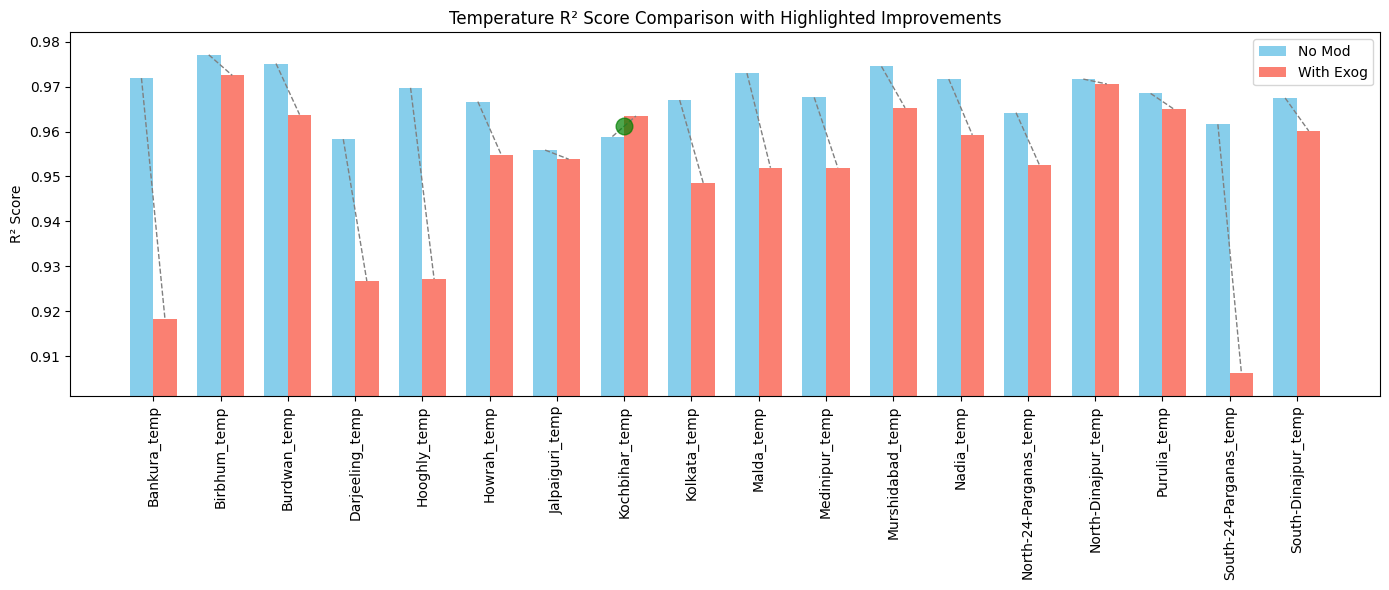

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# find R2
def find_r2(y_true, y_pred):
    r2_val={}
    for col in y_true:
        r2_val[col]=r2_score(y_true[col], y_pred[col])
    return r2_val

# Your data
r2_nomod = find_r2(test_data, predict_result_no_mod)
r2_exog = find_r2(test_data, lstm_pred_data)

labels = list(r2_nomod.keys())
x = np.arange(len(labels))
width = 0.35

# Get values
nomod_values = list(r2_nomod.values())
exog_values = list(r2_exog.values())

plt.figure(figsize=(14, 6))

# Bars
plt.bar(x - width/2, nomod_values, width, label='No Mod', color='skyblue')
plt.bar(x + width/2, exog_values, width, label='With Exog', color='salmon')

# Difference lines and circles
for i in range(len(x)):
    # draw line
    plt.plot(
        [x[i] - width/2, x[i] + width/2],
        [nomod_values[i], exog_values[i]],
        color='gray', linestyle='--', linewidth=1
    )

    # draw big circle if exog > nomod
    if exog_values[i] > nomod_values[i]:
        # x-position halfway between two bars
        mid_x = x[i]
        mid_y = (nomod_values[i] + exog_values[i]) / 2
        plt.plot(mid_x, mid_y, marker='o', markersize=12, color='green', alpha=0.7)
        
        
    #     # draw big circle if exog > nomod
    # if exog_values[i] < nomod_values[i]:
    #     # x-position halfway between two bars
    #     mid_x = x[i]
    #     mid_y = (nomod_values[i] + exog_values[i]) / 2
    #     plt.plot(mid_x, mid_y, marker='o', markersize=12, color='blue', alpha=0.7)

# Axis labels and legend
plt.xticks(x, labels, rotation=90)
plt.ylabel("R² Score")
plt.title("Temperature R² Score Comparison with Highlighted Improvements")
plt.legend()

# Zoom in on small differences
plt.ylim(min(min(nomod_values), min(exog_values)) - 0.005,
         max(max(nomod_values), max(exog_values)) + 0.005)

plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras.models import Sequential, Model
from keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, MultiHeadAttention, LayerNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- Helper: Split Sequence for LSTM ---
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


# --- Parameters ---
n_steps = 15     # More history context
train_end_date = datetime.datetime(1992, 12, 1)

# --- Split Data ---
train_data = df[:train_end_date]
train_test_data = df[train_end_date - relativedelta(months=n_steps - 1):]
acc_test_data = df[train_end_date + relativedelta(months=1):]  
lstm_pred_data = acc_test_data.copy()  

# ✅ SCALE the entire column before splitting
scaler = MinMaxScaler()

# --- Model Selector ---
MODEL_TYPE = "CNN_LSTM"        # Options: "LSTM", "GRU", "CNN_LSTM", "TRANSFORMER"

# --- Loop through columns ---
for col in df.columns[6:7]:  # Skip first 3 columns (Date, District, State)
    print(f"🔵 Training model for: {col}")

    # --- Scale column ---
    scaled_col = scaler.fit_transform(df[col].values.reshape(-1, 1))
    df_scaled = pd.Series(scaled_col.flatten(), index=df.index)

    # --- Prepare data ---
    X_train, y_train = split_sequence(df_scaled[:train_end_date], n_steps)
    X_test, y_test = split_sequence(df_scaled[train_end_date - relativedelta(months=n_steps - 1):], n_steps)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # --- Build Model ---
    if MODEL_TYPE == "LSTM":
        model = Sequential([
            LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps, 1)),
            Dropout(0.3),
            LSTM(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
    elif MODEL_TYPE == "GRU":
        model = Sequential([
            GRU(128, activation='relu', return_sequences=True, input_shape=(n_steps, 1)),
            Dropout(0.3),
            GRU(64, activation='relu'),
            Dropout(0.3),
            Dense(1)
        ])
    elif MODEL_TYPE == "CNN_LSTM":
        model = Sequential([
            Conv1D(filters=50, kernel_size=3, activation='relu', input_shape=(n_steps, 1)),
            MaxPooling1D(pool_size=2),
            LSTM(30, activation='relu'),
            Dropout(0.1),
            Dense(1)
        ])
    elif MODEL_TYPE == "TRANSFORMER":
        inputs = Input(shape=(n_steps, 1))
        x = MultiHeadAttention(num_heads=2, key_dim=16)(inputs, inputs)
        x = LayerNormalization()(x)
        x = LSTM(64, activation='relu')(x)
        outputs = Dense(1)(x)
        model = Model(inputs, outputs)

    # --- Compile ---
    model.compile(optimizer='adam', loss='mse')

    # --- Callbacks ---
    early_stop = EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=1e-5)

    # --- Train ---
    model.fit(X_train, y_train, epochs=100, verbose=1, callbacks=[early_stop, lr_scheduler])

    # --- Predict ---
    pred_scaled = model.predict(X_test, verbose=0)
    pred = scaler.inverse_transform(pred_scaled)

    # --- Align predictions to actual dates ---
    pred_index = acc_test_data.index[:len(pred)]
    pred_series = pd.Series(pred.flatten(), index=pred_index)

    # --- Store predictions ---
    lstm_pred_data[col] = pred_series

    # --- R² Score ---
    r2 = r2_score(acc_test_data[col], lstm_pred_data[col])
    print(f"✅ {MODEL_TYPE} R² Score for {col}: {r2:.4f}")

    # # --- Plot ---
    # plt.figure(figsize=(12,6))
    # plt.plot(acc_test_data[col], label="Actual", color='blue')
    # plt.plot(lstm_pred_data[col], label=f"{MODEL_TYPE} Prediction", color='red', linestyle='--')
    # plt.title(f"{MODEL_TYPE} Forecast for {col}")
    # plt.legend()
    # plt.show()


🔵 Training model for: Jalpaiguri_temp
Epoch 1/100


/tmp/ipykernel_99304/2666450156.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
/home/radhe/Subha/internship/werather_forcastiing/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2707 - learning_rate: 0.0010
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0848 - learning_rate: 0.0010
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0655 - learning_rate: 0.0010
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0422 - learning_rate: 0.0010
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - learning_rate: 0.0010
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0120 - learning_rate: 0.0010
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - learning_rate: 0.0010
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 - learning_rate: 0.0010
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - learning_rate: 0.0010
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - learning_rate: 0.0010
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - learning_rate: 0.0010
Epoch 12/100
35/35 ━

In [ ]:
%pip install keras-tuner

import pandas as pd
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import keras_tuner as kt  # ✅ Hyperparameter tuning library

# --- Helper: Split sequence for supervised learning ---
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# --- Data Setup ---
n_steps_default = 30   # Default; tuner will override
train_end_date = datetime.datetime(1992, 12, 1)

train_data = df[:train_end_date]
train_test_data = df[train_end_date - relativedelta(months=n_steps_default - 1):]
acc_test_data = df[train_end_date + relativedelta(months=1):]  

scaler = MinMaxScaler()

# --- HyperModel Builder for Tuner ---
def build_model(hp):
    model = Sequential()

    # ✅ Choose architecture type dynamically
    model_type = hp.Choice('model_type', ['LSTM', 'GRU', 'CNN_LSTM'])

    # ✅ Hyperparameter choices
    n_steps = hp.Choice('n_steps', [15, 30, 45, 60])
    units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
    dropout_1 = hp.Float('dropout_1', 0.1, 0.5, step=0.1)
    dropout_2 = hp.Float('dropout_2', 0.1, 0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    # ✅ Build model based on type
    if model_type == 'LSTM':
        model.add(LSTM(units_1, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
        model.add(Dropout(dropout_1))
        model.add(LSTM(units_2, activation='relu'))
        model.add(Dropout(dropout_2))

    elif model_type == 'GRU':
        model.add(GRU(units_1, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
        model.add(Dropout(dropout_1))
        model.add(GRU(units_2, activation='relu'))
        model.add(Dropout(dropout_2))

    elif model_type == 'CNN_LSTM':
        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_steps, 1)))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(units_1, activation='relu'))
        model.add(Dropout(dropout_1))

    # Output layer
    model.add(Dense(1))

    # ✅ Compile with tuned learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    return model

# --- Loop through columns (districts) ---
for col in df.columns[3:4]:  # Pick the columns you want to tune
    print(f"🎯 Tuning model for: {col}")

    # ✅ Scale the column
    scaled_col = scaler.fit_transform(df[col].values.reshape(-1, 1))
    df_scaled = pd.Series(scaled_col.flatten(), index=df.index)

    # ✅ Prepare data with default n_steps first
    X_train, y_train = split_sequence(df_scaled[:train_end_date], n_steps_default)
    X_test, y_test = split_sequence(df_scaled[train_end_date - relativedelta(months=n_steps_default - 1):], n_steps_default)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # ✅ Build tuner
    tuner = kt.Hyperband(
        build_model,
        objective='loss',
        max_epochs=50,
        factor=3,
        directory='tuning_results',
        project_name=f"{col}_lstm_tuning"
    )

    # ✅ Early stopping
    stop_early = EarlyStopping(monitor='loss', patience=5)

    # ✅ Run hyperparameter search
    tuner.search(X_train, y_train, epochs=50, callbacks=[stop_early], verbose=1)

    # ✅ Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"""
    🔍 BEST CONFIG FOUND FOR {col}:
    Model Type: {best_hps.get('model_type')}
    n_steps: {best_hps.get('n_steps')}
    Units Layer1: {best_hps.get('units_1')}
    Units Layer2: {best_hps.get('units_2')}
    Dropout1: {best_hps.get('dropout_1')}
    Dropout2: {best_hps.get('dropout_2')}
    Learning Rate: {best_hps.get('learning_rate')}
    """)

    # ✅ Train the best model longer
    best_model = tuner.hypermodel.build(best_hps)
    history = best_model.fit(X_train, y_train, epochs=200, verbose=1, callbacks=[stop_early])

    # ✅ Predict
    pred_scaled = best_model.predict(X_test)
    pred = scaler.inverse_transform(pred_scaled)

    # ✅ Evaluate performance
    pred_index = acc_test_data.index[:len(pred)]
    r2 = r2_score(acc_test_data[col][:len(pred)], pred.flatten())
    print(f"✅ BEST MODEL R² Score for {col}: {r2:.4f}")

    # ✅ Plot predictions vs. actual
    plt.figure(figsize=(12,6))
    plt.plot(acc_test_data[col], label="Actual", color='blue')
    plt.plot(pred_index, pred, label=f"Best {best_hps.get('model_type')} Prediction", color='red', linestyle='--')
    plt.title(f"Tuned Forecast for {col}")
    plt.legend()
    plt.show()


Trial 41 Complete [00h 00m 28s]
loss: 0.011623152531683445

Best loss So Far: 0.007808120455592871
Total elapsed time: 00h 04m 41s

Search: Running Trial #42

Value             |Best Value So Far |Hyperparameter
GRU               |GRU               |model_type
15                |15                |n_steps
224               |224               |units_1
128               |256               |units_2
0.2               |0.1               |dropout_1
0.4               |0.3               |dropout_2
0.001             |0.01              |learning_rate
6                 |6                 |tuner/epochs
2                 |2                 |tuner/initial_epoch
3                 |3                 |tuner/bracket
1                 |1                 |tuner/round
0017              |0028              |tuner/trial_id

Epoch 3/6
